## Here clients train for different number local epochs

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import defaultdict
import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ===========================
# Data Loading and Preprocessing
# ===========================

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Load the dataset
dataset_all = ImageFolder('Ayana_Bharti/train_mnist_all', transform=data_transform)

# Organize dataset indices by class
def organize_indices_by_class(dataset):
    """
    Organize dataset indices by their class labels.
    
    Args:
        dataset: The dataset with labels to split.
        
    Returns:
        Dictionary with class labels as keys and corresponding indices as values.
    """
    class_indices = defaultdict(list)
    for idx, (data, label) in enumerate(dataset):
        class_indices[label].append(idx)
    return class_indices


In [3]:
def split_dataset_for_non_iid(class_indices, val_ratio=0.2):
    """
    Splits the dataset into non-IID training and validation indices for clients,
    taking the first 80% of images for each class for training.

    Args:
        class_indices: Dictionary of class label -> list of sample indices.
        val_ratio: Proportion of samples to reserve for validation.

    Returns:
        Tuple of train and validation indices for each client.
    """
    train_indices_client1, train_indices_client2, train_indices_client3 = [], [], []
    val_indices_client1, val_indices_client2, val_indices_client3 = [], [], []

    total_samples = 0  # To track total samples
    for label in class_indices:
        # Extract class label (handles string labels like "5_0")
        class_label = int(label.split('_')[0]) if isinstance(label, str) else label
        class_samples = class_indices[label]

        # Debug: Print the class and number of samples
        print(f"Class {class_label}: {len(class_samples)} samples")

        total_samples += len(class_samples)
        if not class_samples:
            continue

        # Sort class samples to ensure consistent ordering
        class_samples = sorted(class_samples)

        # Split into first 80% for training and last 20% for validation
        split_point = int(0.8 * len(class_samples))
        train_samples = class_samples[:split_point]
        val_samples = class_samples[split_point:]

        if class_label in [0, 1, 2]:  # Client 1 classes
            train_indices_client1.extend(train_samples)
            val_indices_client1.extend(val_samples)
        elif class_label in [3, 4]:  # Client 2 classes
            train_indices_client2.extend(train_samples)
            val_indices_client2.extend(val_samples)
        elif class_label in [5, 6]:  # Client 3 classes
            train_indices_client3.extend(train_samples)
            val_indices_client3.extend(val_samples)
        else:
            print(f"Unassigned class {class_label}: {len(class_samples)} samples")

    # Debug: Print the total number of samples
    print(f"Total samples: {total_samples}")
    print(f"Client 1: Training {len(train_indices_client1)}, Validation {len(val_indices_client1)}")
    print(f"Client 2: Training {len(train_indices_client2)}, Validation {len(val_indices_client2)}")
    print(f"Client 3: Training {len(train_indices_client3)}, Validation {len(val_indices_client3)}")

    return (
        train_indices_client1, 
        train_indices_client2, 
        train_indices_client3, 
        val_indices_client1, 
        val_indices_client2, 
        val_indices_client3
    )


In [4]:
# Create Subsets
def create_subsets(dataset, indices):
    """
    Creates a subset of the dataset based on the provided indices.
    
    Args:
        dataset: The complete dataset.
        indices: List of indices to include in the subset.
        
    Returns:
        Subset object containing the specified indices.
    """
    return Subset(dataset, indices)


In [5]:
def create_dataloader(subset, batch_size=64, shuffle=True):
    if len(subset) == 0:
        raise ValueError("Subset is empty. Ensure data split logic is correct.")
    print(f"Creating DataLoader with {len(subset)} samples.")
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)


In [6]:
def get_last_20_percent_indices(class_indices):
    test_indices = []
    for label, indices in class_indices.items():
        if not indices:
            continue
        indices = sorted(indices)
        split_point = int(0.8 * len(indices))
        test_indices.extend(indices[split_point:])
    return test_indices

In [7]:
# ===========================
# Organize and Split Data
# ===========================

# Organize indices by class
class_indices = organize_indices_by_class(dataset_all)

# Split dataset for non-IID simulation
train_indices_client1, train_indices_client2,train_indices_client3 , val_indices_client1, val_indices_client2, val_indices_client3 = split_dataset_for_non_iid(class_indices, val_ratio=0.2)

# Create Subsets
subset_client1 = create_subsets(dataset_all, train_indices_client1)
print(f"Client 1 subset size: {len(subset_client1)}")
subset_client2 = create_subsets(dataset_all, train_indices_client2)
print(f"Client 2 subset size: {len(subset_client2)}")
subset_client3 = create_subsets(dataset_all, train_indices_client3)
print(f"Client 3 subset size: {len(subset_client3)}")
subset_val_client1 = create_subsets(dataset_all, val_indices_client1)
subset_val_client2 = create_subsets(dataset_all, val_indices_client2)
subset_val_client3 = create_subsets(dataset_all, val_indices_client3)
# DataLoaders
batch_size = 64
loader_client1 = create_dataloader(subset_client1, batch_size=batch_size, shuffle=True)
loader_client2 = create_dataloader(subset_client2, batch_size=batch_size, shuffle=True)
loader_client3 = create_dataloader(subset_client3, batch_size=batch_size, shuffle=True)
val_loader_client1 = create_dataloader(subset_val_client1, batch_size=batch_size, shuffle=False)
val_loader_client2 = create_dataloader(subset_val_client2, batch_size=batch_size, shuffle=False)
val_loader_client3 = create_dataloader(subset_val_client3, batch_size=batch_size, shuffle=False)

#test dataset
test_indices = get_last_20_percent_indices(class_indices)
test_subset = create_subsets(dataset_all, test_indices)
test_loader = create_dataloader(test_subset, batch_size=64, shuffle=False)


# Summary of Data Distribution
print(f"Client 1 training samples: {len(subset_client1)}, validation samples: {len(subset_val_client1)}")
print(f"Client 2 training samples: {len(subset_client2)}, validation samples: {len(subset_val_client2)}")
print(f"Client 3 training samples: {len(subset_client3)}, validation samples: {len(subset_val_client3)}")
print(f"Test set size: {len(test_subset)}")


Class 0: 8638 samples
Class 1: 9897 samples
Class 2: 8663 samples
Class 3: 8984 samples
Class 4: 8537 samples
Class 5: 7916 samples
Class 6: 8653 samples
Class 7: 9127 samples
Unassigned class 7: 9127 samples
Class 8: 8499 samples
Unassigned class 8: 8499 samples
Class 9: 8700 samples
Unassigned class 9: 8700 samples
Total samples: 87614
Client 1: Training 21757, Validation 5441
Client 2: Training 14016, Validation 3505
Client 3: Training 13254, Validation 3315
Client 1 subset size: 21757
Client 2 subset size: 14016
Client 3 subset size: 13254
Creating DataLoader with 21757 samples.
Creating DataLoader with 14016 samples.
Creating DataLoader with 13254 samples.
Creating DataLoader with 5441 samples.
Creating DataLoader with 3505 samples.
Creating DataLoader with 3315 samples.
Creating DataLoader with 17527 samples.
Client 1 training samples: 21757, validation samples: 5441
Client 2 training samples: 14016, validation samples: 3505
Client 3 training samples: 13254, validation samples: 3

In [8]:
# ===========================
# Model Definition
# ===========================

class MLP(nn.Module):
    def __init__(self, input_size=14 * 14, hidden_sizes=(128, 64), output_size=10, dropout=0.2):
        """
        A flexible Multi-Layer Perceptron (MLP) for non-IID federated learning.

        Parameters:
        - input_size: Size of the flattened input (default is 14*14 for MNIST-like data).
        - hidden_sizes: Tuple defining the sizes of the hidden layers.
        - output_size: Number of output classes (default is 10).
        - dropout: Dropout probability to mitigate overfitting (default is 0.2).
        """
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

        # Add dropout layers
        self.dropout = nn.Dropout(dropout)

        # Add optional batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input tensor of shape (batch_size, input_size).

        Returns:
        - logits: Output predictions before softmax.
        """
        x = x.view(x.size(0), -1)  # Flatten the input

        # First layer with batch normalization
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Second layer with batch normalization
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Output layer (logits, no activation)
        x = self.fc3(x)
        return x

In [9]:

def evaluate_model(models, dataloaders, criterion, device='cpu'):
    """
    Evaluates multiple models on their respective validation sets.
    
    Args:
        models (dict): Dictionary of model instances (e.g., {'client1': model1, 'client2': model2}).
        dataloaders (dict): Dictionary of corresponding dataloaders (e.g., {'client1': loader1, 'client2': loader2}).
        criterion (torch.nn.Module): Loss function.
        device (str): Device to run evaluation on ('cpu' or 'cuda').

    Returns:
        dict: Performance metrics for each model (e.g., accuracy, loss).
    """
    performance = {}
    for client_id, model in models.items():
        model.to(device)
        model.eval()  # Set the model to evaluation mode

        total_loss = 0.0
        correct = 0
        total_samples = 0

        dataloader = dataloaders[client_id]
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total_samples
        performance[client_id] = {'accuracy': accuracy, 'loss': avg_loss}

    return performance



In [10]:
def evaluate_model_single(model, dataloader, criterion, device='cpu'):
    """
    Evaluates a single model on a given dataloader.
    
    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (DataLoader): DataLoader for the dataset.
        criterion (torch.nn.Module): Loss function.
        device (str): Device to run evaluation on ('cpu' or 'cuda').

    Returns:
        Tuple of (accuracy, average loss).
    """
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    return accuracy, avg_loss


In [11]:
# ===========================
# Training and Evaluation Functions
# ===========================

def train_model(model, dataloader, num_epochs, learning_rate, val_loader=None, device='cpu'):
    """
    Trains a PyTorch model using the provided dataloader, loss function, and optimizer.

    Parameters:
    - model: The neural network to train.
    - dataloader: DataLoader containing the training data.
    - num_epochs: Number of epochs to train the model.
    - learning_rate: Learning rate for the optimizer.
    - val_loader: DataLoader for validation data (optional).
    - device: The device to train on ('cpu' or 'cuda').

    Returns:
    - model: The trained model.
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Move the model to the specified device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the weights

            total_loss += loss.item()  # Sum up the batch loss
            _, predicted = torch.max(outputs, 1)  # Get predictions
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Update total samples

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total_samples * 100

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Optional validation metrics
        if val_loader:
            val_accuracy, val_loss = evaluate_model_single(model, val_loader, criterion, device)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model


In [12]:
# ===========================
# Federated Averaging Function
# ===========================

def server_averaging_non_iid(*local_models, device='cpu'):
    """
    Averages the parameters of multiple local models to create a global model.

    Parameters:
    - *local_models: Variable number of trained local models (e.g., model_all1, model_all2).
    - device: The device ('cpu' or 'cuda') to perform computations on.

    Returns:
    - server_model: The globally averaged model.
    """
    if len(local_models) < 2:
        raise ValueError("At least two models are required for averaging.")

    # Ensure all local models are moved to the correct device and extract their state dictionaries
    local_state_dicts = [model.to(device).state_dict() for model in local_models]

    # Initialize the global model
    server_model = MLP().to(device)
    averaged_params = {}

    # Check if all models have the same architecture (parameter shapes)
    state_dict_keys = [list(model.state_dict().keys()) for model in local_models]
    if any(keys != state_dict_keys[0] for keys in state_dict_keys):
        raise ValueError("All models must have the same architecture (parameter shapes).")

    # Parameter Averaging
    for key in local_state_dicts[0]:  # Iterate over the parameter keys
        # Averaging the parameters of local models
        averaged_params[key] = sum(local_state_dict[key].float() for local_state_dict in local_state_dicts) / len(local_state_dicts)
        
    # Load averaged parameters into the server model
    server_model.load_state_dict(averaged_params)

    # Save the server model parameters to a file
    os.makedirs('textfiles', exist_ok=True)  # Ensure the directory exists
    torch.save(server_model.state_dict(), 'textfiles/server_3clients_2mismatch.pt')  # Changed extension to .pt for PyTorch models

    return server_model


In [13]:
# ===========================
# Testing Function
# ===========================

def test_accuracy_non_iid(model, test_loader, client_loaders=None, device='cpu'):
    """
    Evaluates the accuracy of a global model on a test set and optionally per client.

    Parameters:
    - model: The global model to evaluate.
    - test_loader: DataLoader containing the global test dataset.
    - client_loaders (optional): Dictionary of client DataLoaders to evaluate accuracy per client.
    - device: The device ('cpu' or 'cuda') to run the evaluation on.

    Returns:
    - global_accuracy: The accuracy of the model on the global test dataset, in percentage.
    - client_accuracies (if client_loaders provided): Dictionary with accuracy for each client.
    """
    model.to(device)
    model.eval()

    # Global test accuracy
    correct_global = 0
    total_global = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update counts
            total_global += labels.size(0)
            correct_global += (predicted == labels).sum().item()

    global_accuracy = 100.0 * correct_global / total_global if total_global > 0 else 0.0
    print(f"Global Test Accuracy: {global_accuracy:.2f}%")

    # Per-client accuracy (if client loaders are provided)
    client_accuracies = {}
    if client_loaders:
        for client_id, client_loader in client_loaders.items():
            correct_client = 0
            total_client = 0
            with torch.no_grad():
                for images, labels in client_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)

                    total_client += labels.size(0)
                    correct_client += (predicted == labels).sum().item()

            client_accuracy = 100.0 * correct_client / total_client if total_client > 0 else 0.0
            client_accuracies[client_id] = client_accuracy
            print(f"Accuracy for {client_id}: {client_accuracy:.2f}%")

    return global_accuracy, client_accuracies if client_loaders else global_accuracy


In [14]:
# ===========================
# Federated Learning Simulation
# ===========================

def NonIID_simulation(local_epochs_dict, Global_round, lr, loader_client1, loader_client2, loader_client3,testloader):
    """
    Simulates Federated Learning with clients training for different numbers of local epochs.

    Args:
        local_epochs_dict (dict): Dictionary mapping client IDs to their number of local epochs.
                                  e.g., {'client1': 2, 'client2': 3}
        Global_round (int): Number of global communication rounds.
        lr (float): Learning rate for local optimizers.
        loader_client1 (DataLoader): DataLoader for Client 1's training data.
        loader_client2 (DataLoader): DataLoader for Client 2's training data.
        testloader (DataLoader): DataLoader for the global test dataset.

    Returns:
        final_global_accuracy (float): Accuracy of the global model on the test set after all rounds.
    """
    # Initialize the global model
    initial_model = MLP()
    
    # Load pre-trained global model if available
    model_path = 'textfiles/server_3clients_2mismatch.pt'
    if os.path.isfile(model_path):
        try:
            initial_model.load_state_dict(torch.load(model_path))
            print("Loaded saved global model weights.")
        except Exception as e:
            print(f"Error loading model weights: {e}. Starting with a new model.")

    # Initialize local models
    local_models = {"client1": MLP(), "client2": MLP(), "client3": MLP()}
    
    # Load global model weights into local models
    for client_id, model in local_models.items():
        model.load_state_dict(initial_model.state_dict())
    
    client_dataloaders = {
        "client1": loader_client1,
        "client2": loader_client2,
        "client3": loader_client3,
    }

    # Set the device (CPU or CUDA)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize criterion for evaluation
    criterion = nn.CrossEntropyLoss()

    # Track global accuracies over rounds
    global_accuracies = []

    # Main simulation loop
    for round_idx in range(Global_round):
        print(f"\n===== Global Round {round_idx + 1} =====")

        # Train local models with their respective number of local epochs
        for client_id, model in local_models.items():
            epochs = local_epochs_dict.get(client_id, 1)  # Default to 1 epoch if not specified
            print(f"Training {client_id} for {epochs} local epochs...")
            train_model(model, client_dataloaders[client_id], epochs, lr, val_loader=None, device=device)

        # Evaluate local models
        client_performance = evaluate_model(local_models, client_dataloaders, criterion, device)
        print(f"Client Performance after Round {round_idx + 1}:")
        for client_id, metrics in client_performance.items():
            print(f"  {client_id} - Loss: {metrics['loss']:.4f}, Accuracy: {metrics['accuracy']*100:.2f}%")

        # Perform server averaging to update the global model
        initial_model = server_averaging_non_iid(*local_models.values(), device=device)
        print("Global model updated via server averaging.")

        # Load the updated global model into local models for the next round
        for client_id, model in local_models.items():
            model.load_state_dict(initial_model.state_dict())

        # Evaluate the global model on the test set
        global_accuracy, client_accuracies = test_accuracy_non_iid(initial_model, testloader, client_loaders=client_dataloaders, device=device)
        global_accuracies.append(global_accuracy)

        # Save the global model accuracy for tracking
        os.makedirs('textfiles', exist_ok=True)
        with open('textfiles/accuracy_3clients_2mismatch.txt', 'a') as f:
            f.write(f'Round {round_idx + 1}: Global Accuracy: {global_accuracy:.2f}%, '
                    f'Client1 Accuracy: {client_accuracies["client1"]:.2f}%, '
                    f'Client2 Accuracy: {client_accuracies["client2"]:.2f}%, '
                    f'Client3 Accuracy: {client_accuracies["client3"]:.2f}%\n')
        
        # Save the updated global model
        torch.save(initial_model.state_dict(), model_path)  # Save updated global model

    # Plot global accuracies over rounds
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Global_round + 1), global_accuracies, marker='o', label='Global Model Accuracy(Client1 - 012, Client2 - 34, Client3 - 56,Test - 0-9)\nepoch mismatch(2 clients)')
    plt.xlabel('Global Rounds')
    plt.ylabel('Global Test Accuracy (%)')
    plt.title('Global Test Accuracy Over Federated Learning Rounds')
    plt.grid(True)
    plt.legend()
    plt.savefig('textfiles/Global Accuracy client2&client3 epoch mismatch.png')
    plt.show()

    return global_accuracies[-1] if global_accuracies else None


Using device: cpu

===== Global Round 1 =====
Training client1 for 2 local epochs...
Epoch 1/2, Loss: 0.9592, Accuracy: 87.71%
Epoch 2/2, Loss: 0.2902, Accuracy: 97.90%
Training client2 for 0 local epochs...
Training client3 for 0 local epochs...
Client Performance after Round 1:
  client1 - Loss: 0.1605, Accuracy: 98.68%
  client2 - Loss: 2.3264, Accuracy: 15.77%
  client3 - Loss: 2.2533, Accuracy: 21.44%
Global model updated via server averaging.
Global Test Accuracy: 17.24%
Accuracy for client1: 55.59%
Accuracy for client2: 0.00%
Accuracy for client3: 0.00%

===== Global Round 2 =====
Training client1 for 2 local epochs...
Epoch 1/2, Loss: 0.4643, Accuracy: 97.60%
Epoch 2/2, Loss: 0.1687, Accuracy: 98.33%
Training client2 for 0 local epochs...
Training client3 for 0 local epochs...
Client Performance after Round 2:
  client1 - Loss: 0.0937, Accuracy: 98.90%
  client2 - Loss: 2.3568, Accuracy: 0.00%
  client3 - Loss: 2.3734, Accuracy: 0.00%
Global model updated via server averaging.


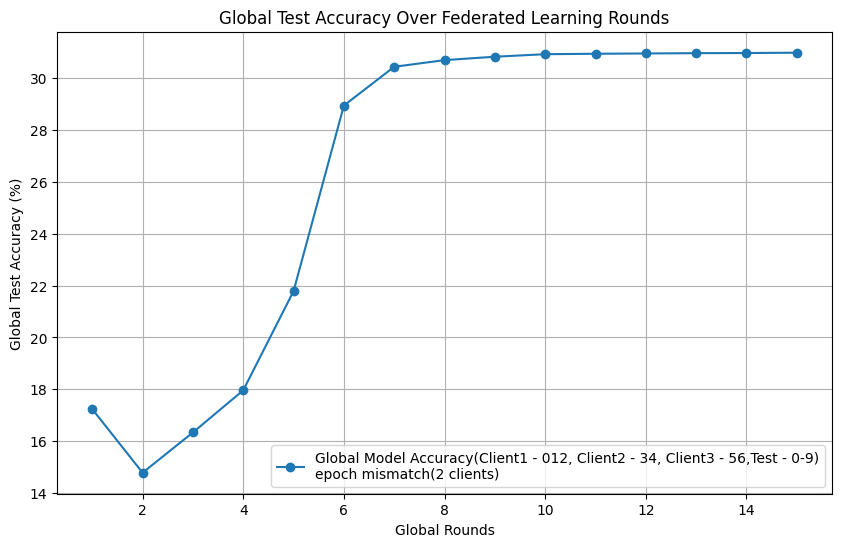


Final Global Test Accuracy after 15 rounds: 30.98%


In [15]:
# ===========================
# Main Execution
# ===========================

if __name__ == "__main__":
    # Define different number of local epochs for each client
    local_epochs_dict = {
        'client1': 2,  # Client 1 trains for 1 epoch per global round
        'client2': 0,  # Client 2 trains for 3 epochs per global round
        'client3': 0,
    }

    # Define other FL parameters
    Global_round = 15
    learning_rate = 0.0001  # Adjusted learning rate for better convergence

    # Run the simulation
    final_accuracy = NonIID_simulation(
        local_epochs_dict=local_epochs_dict,
        Global_round=Global_round,
        lr=learning_rate,
        loader_client1=loader_client1,
        loader_client2=loader_client2,
        loader_client3=loader_client3,
        testloader=test_loader
    )

    print(f"\nFinal Global Test Accuracy after {Global_round} rounds: {final_accuracy:.2f}%")